# Generation of the Hopf Fibration with PYNQ
## Using AXI-Stream

#### Created by Group A : Finlay Harris, Morgan McFarlane, James Petrie

Purpose: <br>Submission for University of Strathclyde: EE315 Further VHDL and FPGA Design <br>

Aim:<br> To generate an artist representation of the Hopf Fibration by passing off computationally challenging sections to the PL section of the SoC to process sections in parallel. The Hopf Fibration generated using the PL should be the same as the one generated in only software. This model uses AXI-stream to communicate between the PL and PS of the SoC. It is hoped that this improves the accuracy of the model compared with using AXI-Lite due to allowing larger data to be sent via the two sections of the chip.<br>

Decription: <br> This notebook contains the software and hardware implementation of an artist representation of the Hopf Fibration using a trigonmetric approach. The hardware approach makes use of AXI-Stream rather than AXI-Lite. The two methods are timed to compare which method is faster. <br>

### What is the Hopf Fibration?

The Hopf fibration is a fascinating and fundamental concept in the field of topology, a branch of mathematics. It was discovered by Heinz Hopf in 1931. This fibration is an example of a map from one sphere to another sphere of lower dimension, specifically from a 3-dimensional sphere \( S^3 \) to a 2-dimensional sphere \( S^2 \).

The Hopf fibration is significant because it is one of the first discovered examples of a fiber bundle where the total space and the base space are both spheres but of different dimensions. It illustrates a deep geometric and topological structure, showing that \( S^3 \) can be thought of as a union of circles (1-dimensional spheres), each of which is parameterized by points on \( S^2 \).

This concept has profound implications in various fields of mathematics and physics, particularly in the study of complex numbers and quaternionic structures. The fibers in the Hopf fibration are circles, and each fiber is linked with every other fiber exactly once, demonstrating an elegant intertwining structure.

![Hopf Fibration Visualization](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Hopf_Fibration.png/1200px-Hopf_Fibration.png)


### Include Relevant Libraries:
- **numpy** - To handle arrays in python.
- **matplotlib** and **mpl_toolkits.mplot3d** - For plotting 3D visuals.
- **PYNQ overlay** and **allocate** - To enable interaction with programmable logic (PL) on PYNQ-enabled devices.
- **time** - To record the elapsed time of processes.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pynq import allocate
from pynq import Overlay
import time

### Generating Inputs for Software & Hardware

The inputs to the system are three angles, each with a specific range and purpose:

1. **Alpha**: This angle typically represents a rotation around the vertical axis. In the context of this system, it ranges from $ 0$ to  $4pi$  radians, allowing for two full rotations, which could be necessary for certain types of symmetry or periodic functions.

2. **Phi**: Often denoted as the azimuthal angle in spherical coordinates, it represents a rotation around the horizontal axis. For our system,  $phi $ spans from $ 0 $ to $pi $ radians, corresponding to a semi-circle from one pole to the other.

3. **Theta**: This is the polar or inclination angle, measuring the angle from the zenith direction. In our setup, $theta$  varies between $ 0 $ and 2$pi $ radians, which covers a complete rotation around the axis, similar to latitude in geographic coordinates.

Each angle is sampled into 50 points, resulting in a set of 50 unique values for $alpha$, $phi$ , and $theta$, which are used as inputs for the system to define points on a sphere in three-dimensional space or to control the orientation of a physical device in the case of hardware applications.



In [2]:
# Function to generate an array of angle samples based off the range given in the parameters
# Parameters: start- start of range, end - end of range, num_points - number of elements in array
def generate_angle_array(start, end, num_points):
    return np.linspace(start, end, num=num_points)

In [3]:
# Define the angles
num_points = 100
alpha_array = generate_angle_array(0, 4*np.pi, num_points)
phi_array = generate_angle_array(0, np.pi, num_points)
theta_array = generate_angle_array(0, 2*np.pi, num_points)

<IPython.core.display.Javascript object>


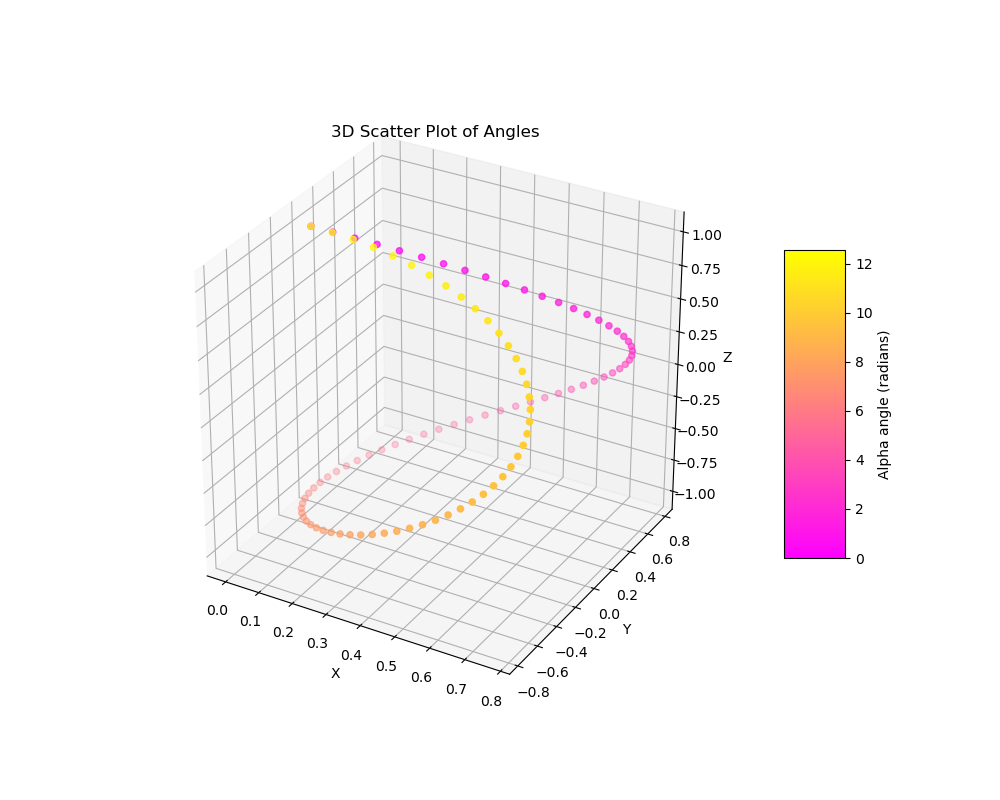

In [4]:
# Generate a 3D Plot to visualise angles generated
##################################################

# Transform spherical coordinates to Cartesian coordinates for the plot
x = np.sin(theta_array) * np.cos(phi_array)
y = np.sin(theta_array) * np.sin(phi_array)
z = np.cos(theta_array)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(x, y, z, c=alpha_array, cmap='spring')

# Colorbar to show the alpha values
colorbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
colorbar.set_label('Alpha angle (radians)')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
ax.set_title('3D Scatter Plot of Angles')

# Show the plot
plt.show()

### Software Implementation
##### Generate the Hopf Map:

In [5]:
# Function to calculate the Hopf Map
####################################

def hopf_map(alpha, phi, theta):
    """
    Parametrise the 3-sphere in 4D space using the Hopf fibration.
    
    :param alpha: angle ranging from 0 to 4π
    :param phi: angle ranging from 0 to 2π
    :param theta: angle ranging from 0 to 2π
    :return: tuple (X0, X1, X2, X3) representing a point in 4D space
    """
   

    X0 = np.cos((alpha + phi) / 2) * np.sin(theta / 2)
    X1 = np.sin((alpha + phi) / 2) * np.sin(theta / 2)
    X2 = np.cos((alpha - phi) / 2) * np.cos(theta / 2)
    X3 = np.sin((alpha - phi) / 2) * np.cos(theta / 2)
    
    return X0, X1, X2, X3

##### Perform Stereographic Projection:

In [6]:
# Function to perform stereographic projection (drop a dimension)
#################################################################

def stereographic_projection(X0, X1, X2, X3):
    """
    Parametrise the 4D Coordinates to 3D.
    
    :param X0,X1,X2,X3: 4D Coordinates
    :return: x,y,z representing a point in 3D space
    """

    # Avoid division by zero in case X3 is 1
    denom = 1 - X3
    # Use np.where to handle near-zero values
    denom = np.where(np.isclose(denom, 0), np.finfo(float).eps, denom)
    
    x = X0 / denom
    y = X1 / denom
    z = X2 / denom
    
    return x, y, z

##### Generating the Software Results:

In [9]:
# Function to plot defined number of Fibres on the Hopf Fibration
#################################################################

def visualise_hopf_fibration(num_fibers=200, num_points_per_fiber=1000):
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Colour map
    colours = plt.cm.twilight_shifted(np.linspace(0, 1, num_fibers))
    
    start = time.time()

    for i in range(num_fibers):
        phi = 2 * np.pi * (i / num_fibers)  # Constant for each fiber
        alpha = np.linspace(0, 4 * np.pi, num_points_per_fiber)
        theta = np.linspace(0, 2 * np.pi, num_points_per_fiber)  # Varies along each fiber 
        
        # Calculate 4D Coordinates
        X0, X1, X2, X3 = hopf_map(alpha, phi, theta)
        # Drop a dimension
        x, y, z = stereographic_projection(X0, X1, X2, X3)
        
        # Find the maximum absolute coordinate from x, y, z
        max_coord = np.max([np.abs(x).max(), np.abs(y).max(), np.abs(z).max()])

        # Normalize the coordinates so that all are within the range [-1, 1]
        x_normalised = x / max_coord
        y_normalised = y / max_coord
        z_normalised = z / max_coord
        ax.plot(x_normalised, y_normalised, z_normalised, color=colours[i], alpha=0.6)
        
    elapsed_time = time.time() - start
    print("Total Time to calcualte 4D Coordinates & perform Stereographic Projection = ", elapsed_time, " seconds" )

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Hopf Fibration Visualisation')
    plt.show()

<IPython.core.display.Javascript object>


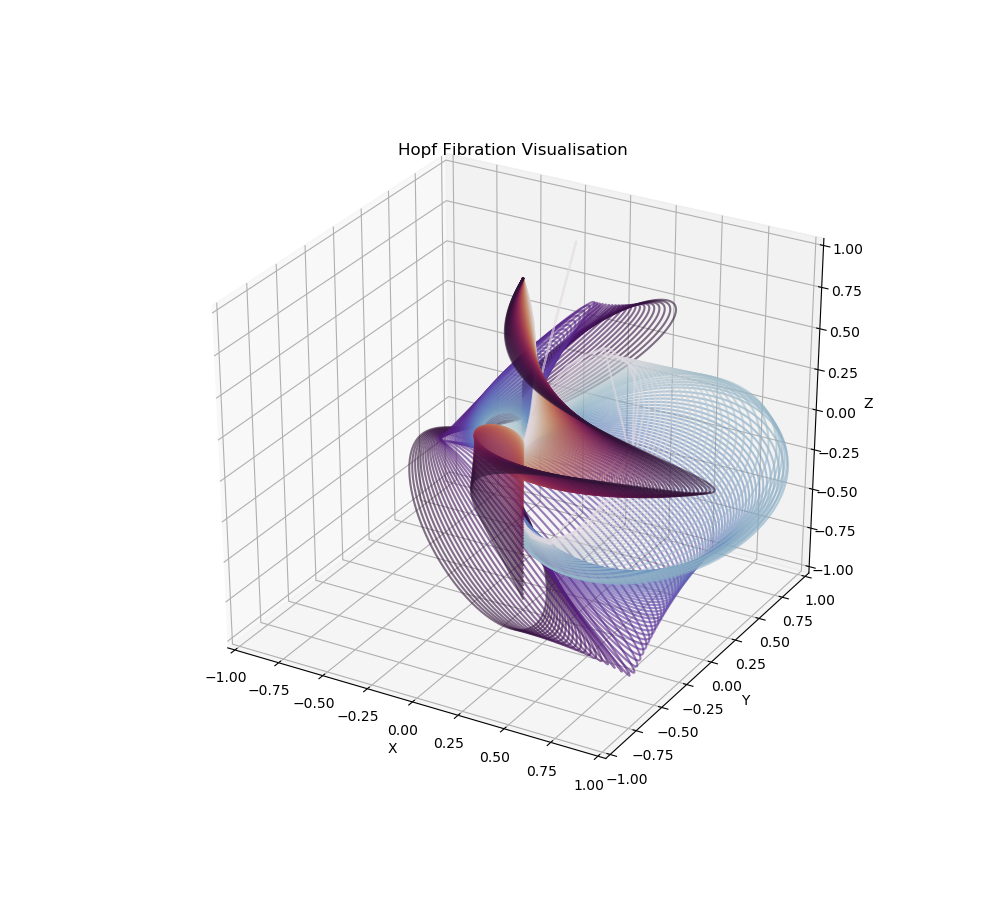

Total Time to calcualte 4D Coordinates & perform Stereographic Projection =  4.243622064590454  seconds
TotalTime to generate =  4.482349157333374  seconds


In [10]:
start = time.time()

# Generate and visualise the Hopf fibration
visualise_hopf_fibration()

elapsed_time = time.time() - start
print("TotalTime to generate = ", elapsed_time, " seconds" )

### Hardware implementation:
##### Import Hopf Fibration hardware:
The hardware was created using model composer and exported to Vivado to generate a bitstream and hardware handoff file.

In [12]:
ol = Overlay("Hopf_AXIStream.bit")
ol?

In [13]:
dma = ol.axi_dma

#### Formatting angle inputs
This consisted of interleaving the arrays of angles generated earlier. This was done as the AXI-Stream IP required the data to be input as a singular stream in the form of an unsigned 32 bit fixed point number.

In [14]:
# Interleave arrays
interleaved_array = np.zeros(num_points * 3, dtype=np.uint32)
interleaved_array[0::3] = (alpha_array  * 0xFFFFFFFF).astype(np.uint32)
interleaved_array[1::3] = (phi_array  * 0xFFFFFFFF).astype(np.uint32)
interleaved_array[2::3] = (theta_array  * 0xFFFFFFFF).astype(np.uint32)

#### Managing Input and Output Buffers for AXI Stream

In [15]:
# Allocate input and output buffers
input_buffer = allocate(shape=(interleaved_array.size,), dtype=np.uint32)
output_buffer = allocate(shape=(interleaved_array.size,), dtype=np.uint32)

In [16]:
# Load data into input buffer
np.copyto(input_buffer, interleaved_array)

In [17]:
start = time.time()

# Transfer Data
dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()

elapsed_time = time.time() - start
print("Total Time to calcualte 4D Coordinates = ", elapsed_time, " seconds" )

Total Time to calcualte 4D Coordinates =  0.0041656494140625  seconds


In [18]:
output_buffer

PynqBuffer([1803487768, 2139056256, 2135034495, 2139127679, 2139062144,
            2139062400, 2139062399,  209748095, 2139127679, 2139056256,
            2139044922, 2139062143, 2139062400,  645865343, 2139127936,
            2139062033, 2139062143, 1283424128, 1300201344, 2139047168,
            2139121791, 2135195776, 2139047168, 2139043967, 2139062400,
            2139047168, 2139062399, 2139044991, 2139047168, 2139127936,
            2139062399, 2139047168, 2131722111, 2139103103, 2139047168,
            2139127935, 2139127680, 2139047168,  614825945, 2139127680,
            2139047168, 2139062399, 2139127935, 2139047168, 2139127935,
            2139047168, 2139047168, 1971355519, 2139047168, 2139047168,
            2139062399, 2139047168, 2139047168, 2139127679, 2139047168,
            2139047168, 2139110417, 2139047168, 2139047168, 2139062143,
            2139047168, 2139047168, 2139062400, 2139047168, 2139047168,
            2139060863, 2139047168, 2139047168, 2139037455, 2139

#### Formatting Output Data
The output from the AXI-Stream is in the form of an interleaved array of type unsigned 32 bits, with 0 fractional bits. This array needs to be split into four 8 bit floating point numbers.

In [19]:
# Prepare the arrays for x0, x1, x2, x3
x0 = np.zeros(len(output_buffer), dtype=np.float32)
x1 = np.zeros(len(output_buffer), dtype=np.float32)
x2 = np.zeros(len(output_buffer), dtype=np.float32)
x3 = np.zeros(len(output_buffer), dtype=np.float32)


In [20]:
# Iterate over each 32-bit value and split it into four 8-bit segments
for i, value in enumerate(output_buffer):
    x0_8bit = (value >> 24) & 0xFF
    x1_8bit = (value >> 16) & 0xFF
    x2_8bit = (value >> 8) & 0xFF
    x3_8bit = value & 0xFF

    # Normalise points to lie on S^3
    norm = np.sqrt(x0_8bit**2 + x1_8bit**2 + x2_8bit**2 + x3_8bit**2)
    x0[i] = x0_8bit / norm
    x1[i] = x1_8bit / norm
    x2[i] = x2_8bit / norm
    x3[i] = x3_8bit / norm

# x0, x1, x2, x3 arrays contain the corresponding normalised values lying on S^3
print("x0:", x0)
print("x1:", x1)
print("x2:", x2)
print("x3:", x3)


x0: [0.6365665  0.5208331  0.6628082  0.4990148  0.4990148  0.49803537
 0.4990148  0.05418781 0.4990148  0.5208331  0.64126694 0.5
 0.49803537 0.20410353 0.49706173 0.57563376 0.5        0.32579342
 0.3296171  0.6600721  0.5208331  0.54896116 0.6600721  0.5595039
 0.49803537 0.6600721  0.4990148  0.5570015  0.6600721  0.49706173
 0.4990148  0.6600721  0.5760126  0.5702296  0.6600721  0.49803537
 0.49803537 0.6600721  0.1188572  0.49803537 0.6600721  0.4990148
 0.49803537 0.6600721  0.49803537 0.6600721  0.6600721  0.468634
 0.6600721  0.6600721  0.4990148  0.6600721  0.6600721  0.4990148
 0.6600721  0.6600721  0.66564256 0.6600721  0.6600721  0.5
 0.6600721  0.6600721  0.49803537 0.6600721  0.6600721  0.5048953
 0.6600721  0.6600721  0.6944558  0.6600721  0.6600721  0.4990148
 0.6600721  0.6600721  0.5        0.6600721  0.6600721  0.49803537
 0.6600721  0.6600721  0.49803537 0.6600721  0.6600721  0.49803537
 0.6600721  0.6600721  0.49803537 0.6600721  0.6600721  0.18125354
 0.6600721  

#### Generate Results from Hardware

No need to manually calculate the Hopf Map since the IP core takes care of it! The function below utilises the output from the AXI-Stream, applying a stereographic projection to convert the 4D coordinates to 3D. These 3D coordinates are then plotted to visualise each fiber based on the angle data.


In [23]:
# Function to visualise and generate the Hopf Fibration using Hardware
######################################################################

def visualise_hopf_fibration2(num_fibers=200, num_points_per_fiber=1000):
    # Create a new figure for 3D plotting
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define a color gradient for the different fibers
    colors = plt.cm.twilight_shifted(np.linspace(0, 1, num_fibers))
    
    # Pre-allocate numpy arrays for storing the coordinates of all points
    x_all = np.zeros((num_fibers * num_points_per_fiber))
    y_all = np.zeros_like(x_all)
    z_all = np.zeros_like(x_all)
    
    start = time.time()
    
   
    for i in range(num_fibers):
        phi = 2 * np.pi * i / num_fibers
        alpha = np.linspace(0, 4 * np.pi, num_points_per_fiber)
        theta = np.linspace(0, 2 * np.pi, num_points_per_fiber)
        
        # Generate 4D coordinates 
        x, y, z = stereographic_projection(x0, x1, x2, x3)  
        
        # Check lengths
        actual_length = len(x)  
        idx_start = i * num_points_per_fiber
        idx_end = idx_start + actual_length
        
        x_all[idx_start:idx_end] = x
        y_all[idx_start:idx_end] = y
        z_all[idx_start:idx_end] = z
    
    # Normalise the coordinates to fit within the plot area
    max_coord = np.max([np.abs(x_all).max(), np.abs(y_all).max(), np.abs(z_all).max()])
    x_all /= max_coord
    y_all /= max_coord
    z_all /= max_coord
    
    # Plot all fibres
    for i in range(num_fibers):
        idx_start = i * num_points_per_fiber
        idx_end = idx_start + num_points_per_fiber
        ax.plot(x_all[idx_start:idx_end], y_all[idx_start:idx_end], z_all[idx_start:idx_end], color=colors[i], alpha=0.6)
    
    elapsed_time = time.time() - start
    print("Total time to perform Stereographic Projection = ", elapsed_time, " seconds")
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Hopf Fibration Visualisation')
    plt.show()


<IPython.core.display.Javascript object>


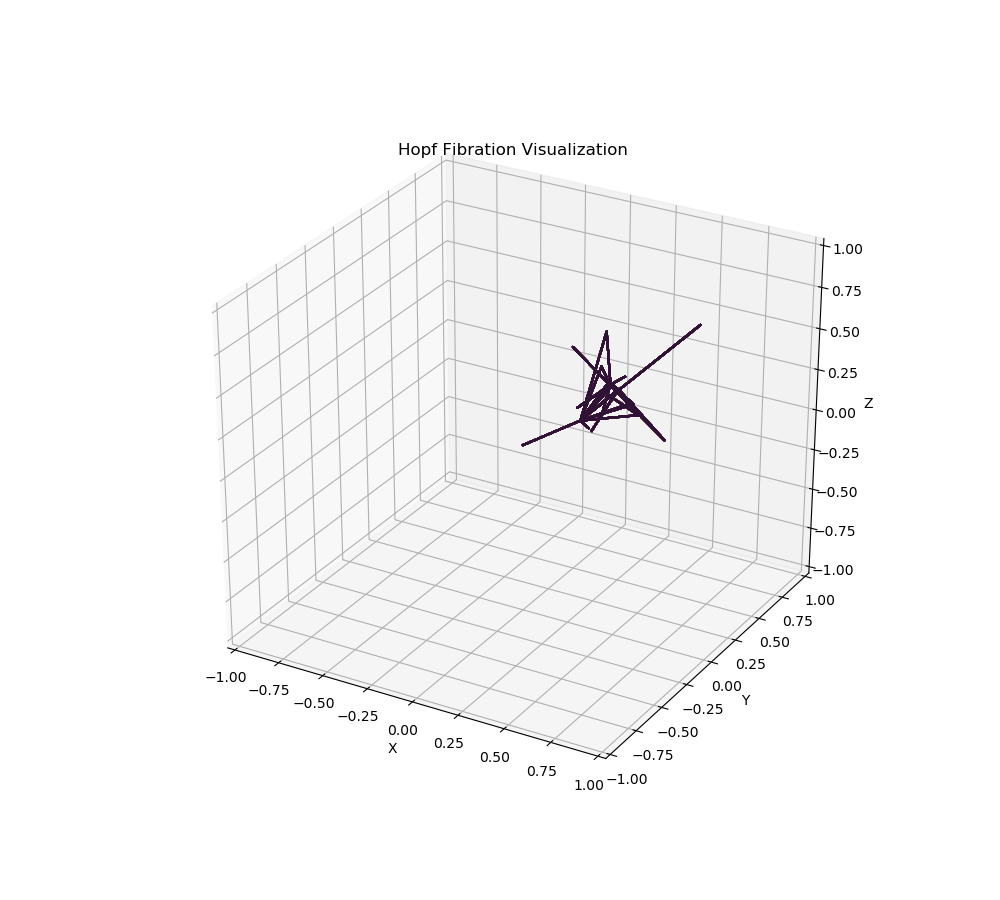

Total time to perform Stereographic Projection =  3.4504950046539307  seconds
Total Time to generate =  3.786292314529419  seconds


In [24]:
start = time.time()
# Generate and visualise the Hopf fibration
visualise_hopf_fibration2()
elapsed_time = time.time() - start
print("Total Time to generate = ", elapsed_time, " seconds" )

## Discussion & Conclusions

The **Generation of the Hopf Fibration using PYNQ with AXI-Stream** aimed to harness the computational capabilities of the Programmable Logic (PL) section of a System on Chip (SoC) to effectively parallelise the rendering of this complex topological structure. 

### Hardware vs. Software Performance
The experiment utilised the AXI-Stream interface, allowing for efficient large data transfers between the PL and the Processing System (PS), which is an upgrade from the more limited AXI-Lite interface used in prior projects. This was expected to provide not only faster data handling but also improved accuracy in the intricate computations required for the Hopf Fibration.

Despite these enhancements, the results presented a varied picture:
- **Hardware Implementation**: The use of FPGA and the AXI-Stream facilitated quicker computation times compared to traditional methods, particularly evident in the rapid handling of 4D coordinates and stereographic projections.
- **Software Implementation**: Though typically slower due to sequential processing, the software implementation allowed for greater flexibility and easier debugging. It also served as a vital benchmark to ensure the accuracy of the hardware output.

### Observations and Insights
- **Accuracy and Precision**: The hardware execution required a pragmatic approach to the approximation of the Hopf Fibration, with adjustments for trigonometric function calculations. Due to the constraints of the hardware, trigonometric functions were approximated using Taylor series expansions. However, to accommodate the limited resources on the Zynq chip, iterations in these series had to be cut, leading to heavily approximated angles and thus impacting the accuracy of the result. This resulted in a representation that, while demostrated some of the Hopf Fibration's structure, deviated from the precision of the software-generated model.
- **Visualisation and Interpretation**: The visualisations, aiming to capture the essence of the Hopf Fibration, faced limitations due to the digital rendering of multidimensional data. The FPGA's computational model was thus unable to capture the full complexity of the fibration, leading to an incomplete representation. This also leads to varied representations from different sources, hence a true reflection of the Hopf Fibration is difficult to obtain. 

### Technical Challenges and Resolutions
- **Data Transmission**: The data transmission phase revealed scalability issues, where data transfer rates did not consistently match the growth in data volume. This misalignment suggests opportunities for enhancing bus architecture and data protocol efficiency.
- **Computation Precision**: The use of fixed-point arithmetic in FPGA computations posed significant challenges, especially in the context of continuous mathematical functions. The requirement to fit the netlist on the Zynq chip meant that only a limited number of iterations for the Taylor series could be computed, compromising the precision of trigonometric calculations and, by extension, the overall visual output.

### Future Directions
Given the foundational successes and the challenges encountered, several pathways can be outlined for future development:
- **Enhanced Data Interfaces**: Upgrading to more advanced data handling interfaces or optimising the current AXI-Stream setup could help in managing larger datasets more efficiently.
- **Algorithm Optimisation**: Further refinement of the algorithms used for generating and projecting the Hopf Fibration may yield faster computation times and higher precision such as using quaternions.
- **Larger SoC**: Implementing on a more sophisticated SoC would allow for more iterations of the Taylor series due to having more available resources.

### Conclusion
This project demonstrates the practical application of FPGAs in enhancing computational tasks in mathematical visualisations and provides a foundation for further exploration into more optimised hardware implementations.

---
